In [141]:
import sounddevice as sd
from scipy.io.wavfile import write
import os
import IPython.display as ipd
import librosa
import librosa.display
import pandas as pd
import time
import warnings
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [23]:
def record_2_sec_voice(folder_path):
    fs = 44100
    seconds = 2 

    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2, dtype="int16")
    print("Recording Audio")
    sd.wait()  
    print("Audio recording complete")
    # sd.play(myrecording, fs)
    # sd.wait()
    # print("Play Audio Complete")
    
    num_files = len([f for f in os.listdir(folder_path)if os.path.isfile(os.path.join(folder_path, f))])
    write(folder_path + "/output" + str(num_files) + ".wav", fs, myrecording) 

In [24]:
def record_wake_word(num_files):
    path = "../data/wake_word"

    ipd.clear_output(wait=True)
    for i in tqdm(range(num_files)):
        record_2_sec_voice(path)
        print("Recorded Wake Word")
        ipd.clear_output(wait=True)
        time.sleep(1)

In [25]:
def record_not_wake_word(num_files):
    path = "../data/not_wake_word"
    
    ipd.clear_output(wait=True)
    for i in tqdm(range(num_files)):
        record_2_sec_voice(path)
        print("Recorded Not Wake Word")
        ipd.clear_output(wait=True)
        time.sleep(1)

In [26]:
record_wake_word(100)

100%|██████████| 100/100 [05:09<00:00,  3.10s/it]


In [27]:
record_not_wake_word(100)

100%|██████████| 100/100 [05:09<00:00,  3.10s/it]


In [2]:
wake_words = []
not_wake_words = []

for file in os.listdir("../data/wake_word"):
    if file.endswith(".wav"):
        wake_words.append("../data/wake_word/" + file)
        
for file in os.listdir("../data/not_wake_word"):
    if file.endswith(".wav"):
        not_wake_words.append("../data/not_wake_word/" + file)

In [3]:
wake_words = pd.DataFrame(wake_words, columns=["file"])
wake_words["label"] = "wake_word"

not_wake_words = pd.DataFrame(not_wake_words, columns=["file"])
not_wake_words["label"] = "not_wake_word"

In [86]:
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print(e)
        return None

    return mfccsscaled, mfccs

In [87]:
def get_features(data):
    extracted_features = []
    for idx in tqdm(range(data.shape[0])):
        file_name = data["file"].iloc[idx]
        final_class_labels = data["label"].iloc[idx]
        features, mfccs = extract_features(file_name)
        extracted_features.append([features, final_class_labels])

    return extracted_features, mfccs

In [88]:
wake_word_features, wake_word_mfccs = get_features(wake_words)
not_wake_word_features, not_wake_word_mfccs = get_features(not_wake_words)

100%|██████████| 100/100 [00:01<00:00, 52.77it/s]


In [89]:
wake_word_features_df = pd.DataFrame(wake_word_features, columns=["feature", "label"])
not_wake_word_features_df = pd.DataFrame(not_wake_word_features, columns=["feature", "label"])

In [90]:
def show_mfcc(data):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(data, x_axis="time")
    plt.colorbar()
    plt.title("MFCC")
    plt.tight_layout()
    plt.show()

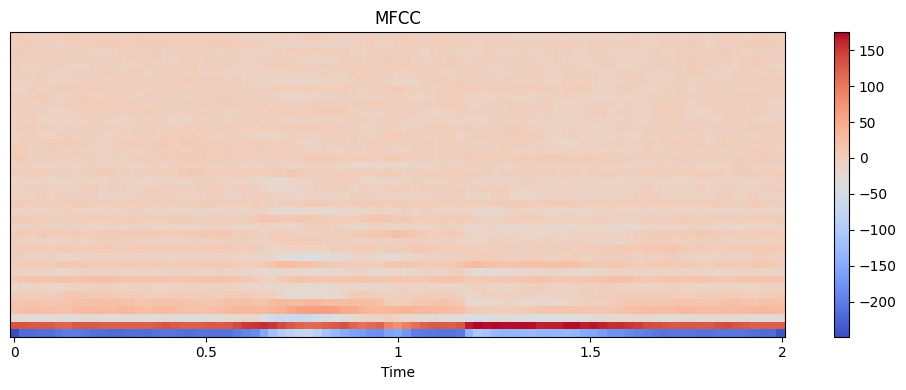

In [97]:
show_mfcc(wake_word_mfccs)

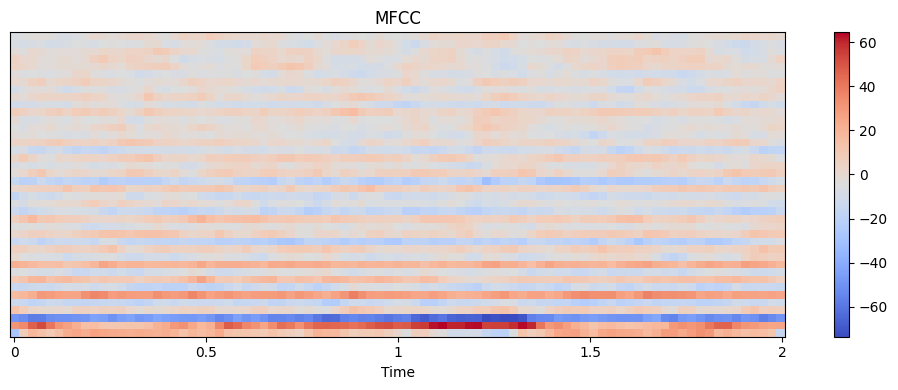

In [98]:
show_mfcc(not_wake_word_mfccs)

In [99]:
wake_word_features_df["feature"] = wake_word_features_df["feature"].apply(lambda x: x / np.max(np.abs(x)))
not_wake_word_features_df["feature"] = not_wake_word_features_df["feature"].apply(lambda x: x / np.max(np.abs(x)))

In [157]:
X = np.array(wake_word_features_df["feature"].tolist())
y = np.array(wake_word_features_df["label"].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
def add_noise(data):
    noise = 0.001 * np.random.uniform(size=len(data))
    return data + noise

def shift(data):
    return np.roll(data, 1600)

def stretch(data, rate=1):
    input_length = 1024
    data = librosa.effects.time_stretch(data, rate=rate)
    if len(data) > input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        
    return data

def pitch(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [115]:
def augment_data(data):
    augmented_data = []
    for idx in range(data.shape[0]):
        feature = data["feature"].iloc[idx]
        label = data["label"].iloc[idx]
        augmented_data.append([feature, label])
        augmented_data.append([add_noise(feature), label])
        augmented_data.append([shift(feature), label])
        augmented_data.append([stretch(feature), label])
        augmented_data.append([pitch(feature, 22050, 4), label])
    return augmented_data

In [116]:
augmented_wake_word_features_df = pd.DataFrame(augment_data(wake_word_features_df), columns=["feature", "label"])
augmented_not_wake_word_features_df = pd.DataFrame(augment_data(not_wake_word_features_df), columns=["feature", "label"])

In [123]:
augmented_wake_word_features_df["label"] = [0 for i in range(augmented_wake_word_features_df.shape[0])]
augmented_not_wake_word_features_df["label"] = [1 for i in range(augmented_not_wake_word_features_df.shape[0])]

In [136]:
augmented_wake_word_features_df

,feature,label
0,"[-1.0, 0.716109, -0.16520076, 0.1400003, 0.069...",0
1,"[-0.9995290755950477, 0.7162409479719508, -0.1...",0
2,"[-1.0, 0.716109, -0.16520076, 0.1400003, 0.069...",0
3,"[-1.0, 0.71610904, -0.16520076, 0.1400003, 0.0...",0
4,"[-0.42779946, 0.31167507, -0.051235676, 0.1141...",0
...,...,...
2495,"[-0.42004567, 0.3270358, -0.048005626, 0.11674...",0
2496,"[-0.4199158782044438, 0.3272472092924529, -0.0...",0
2497,"[-0.42004567, 0.3270358, -0.048005626, 0.11674...",0
2498,"[-0.42004567, 0.3270358, -0.04800563, 0.116740...",0


In [125]:
augmented_not_wake_word_features_df

,feature,label
0,"[-1.0, 0.60646397, -0.07891267, 0.11466855, 0....",1
1,"[-0.999144424734561, 0.6070089109167388, -0.07...",1
2,"[-1.0, 0.60646397, -0.07891267, 0.11466855, 0....",1
3,"[-1.0, 0.60646397, -0.07891267, 0.11466855, 0....",1
4,"[-0.4596668, 0.28230307, -0.016361533, 0.10313...",1
...,...,...
2495,"[0.36065993, 0.05872141, -0.5063251, 0.0748426...",1
2496,"[0.3615950619519105, 0.05880526820685671, -0.5...",1
2497,"[0.36065993, 0.05872141, -0.5063251, 0.0748426...",1
2498,"[0.36065993, 0.058721405, -0.5063251, 0.074842...",1


In [126]:
def create_model():
    model = Sequential()
    model.add(Conv1D(32, 5, activation="relu", input_shape=(40, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 5, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [142]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 36, 32)            192       
                                                                 
 batch_normalization_2 (Batc  (None, 36, 32)           128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 18, 32)           0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 18, 32)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 14, 64)            10304     
                                                                 
 batch_normalization_3 (Batc  (None, 14, 64)          

In [137]:
def prepare_data(data):
    X = np.array(data["feature"].tolist())
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.array(data["label"].tolist())
    return X, y

In [138]:
X_wake_word, y_wake_word = prepare_data(augmented_wake_word_features_df)
X_not_wake_word, y_not_wake_word = prepare_data(augmented_not_wake_word_features_df)

In [177]:
X = np.vstack((X_wake_word, X_not_wake_word))
y = np.hstack((y_wake_word, y_not_wake_word))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
history = model.fit(
    X_train,
    to_categorical(y_train),
    epochs=100,
    batch_size=32,
    validation_data=(X_val, to_categorical(y_val)),
    callbacks=[EarlyStopping(patience=10)],
)

Epoch 1/100
125/125 [==============================] - 1s 6ms/step - loss: 0.2744 - accuracy: 0.8863 - val_loss: 0.6988 - val_accuracy: 0.5000
Epoch 2/100
125/125 [==============================] - 1s 5ms/step - loss: 0.1672 - accuracy: 0.9235 - val_loss: 0.6405 - val_accuracy: 0.7640
Epoch 3/100
125/125 [==============================] - 1s 5ms/step - loss: 0.1316 - accuracy: 0.9435 - val_loss: 0.4334 - val_accuracy: 0.9420
Epoch 4/100
125/125 [==============================] - 1s 5ms/step - loss: 0.1175 - accuracy: 0.9455 - val_loss: 0.3830 - val_accuracy: 0.7420
Epoch 5/100
125/125 [==============================] - 1s 5ms/step - loss: 0.0992 - accuracy: 0.9532 - val_loss: 0.1616 - val_accuracy: 0.9430
Epoch 6/100
125/125 [==============================] - 1s 5ms/step - loss: 0.0804 - accuracy: 0.9638 - val_loss: 0.0777 - val_accuracy: 0.9640
Epoch 7/100
125/125 [==============================] - 1s 5ms/step - loss: 0.0729 - accuracy: 0.9630 - val_loss: 0.0533 - val_accuracy: 0.9730

In [144]:
model.save("../models/wake_word_model.h5")

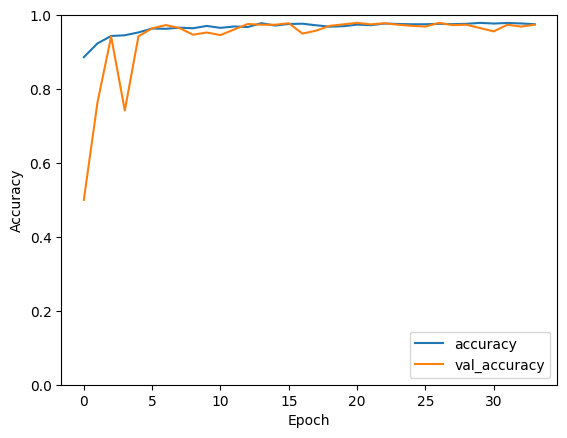

In [146]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

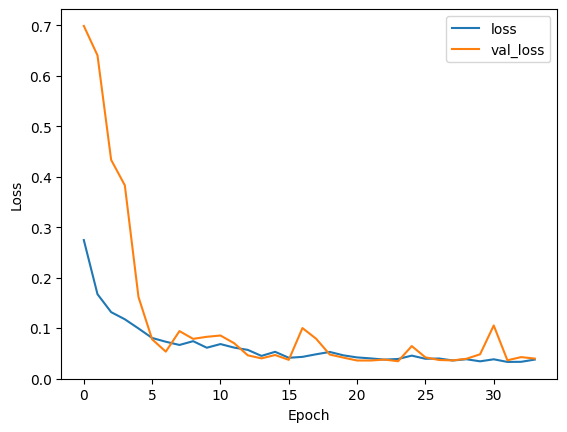

In [147]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

In [152]:
loss, accuracy = model.evaluate(X_test, to_categorical(y_test))
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

32/32 [==============================] - 0s 3ms/step - loss: 0.0396 - accuracy: 0.9740
Test Loss:  0.03955698758363724
Test Accuracy:  0.9739999771118164


1/1 [==============================] - 0s 18ms/step


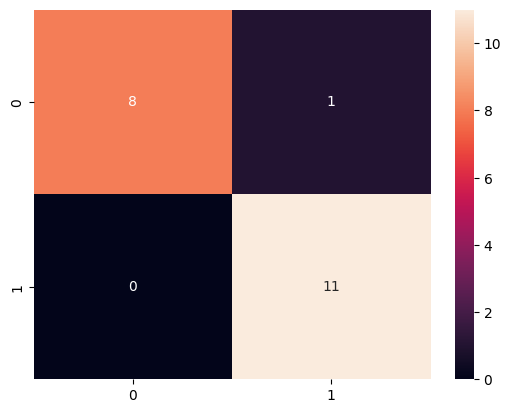

In [178]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(to_categorical(y_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

plt.show()